In [ ]:
from PIL import Image
from pathlib import Path
import numpy as np
import os

os.chdir(r"C:\Users\46028205\Desktop\TP2-Metodos")

print("Ahora estás en:", os.getcwd())


Ahora estás en: C:\Users\46028205\Desktop\TP2-Metodos


Función para vectorizar la imagen en 256x256x1

In [ ]:
def vectorizar_imagen(ruta, size=128, normalizar=False):
    img = Image.open(ruta) 
    img = img.convert("RGB").resize((size, size)) # convierte la imagen a RGB y redimensiona la imagen
    img = np.array(img) # convierte a array
    r = img[:, :, 0] # matriz r
    g = img[:, :, 1] # matriz g
    b = img[:, :, 2] # matriz b
    gray = 0.299*r + 0.587*g + 0.114*b # forma estándar NTSC para pasar RGB a escala de grises
    
    if normalizar: # normalizar el vector
        gray = gray / 255.0
    
    vector = gray.flatten().reshape(-1, 1) # aplanamos a un vector
    
    return vector

Función para calcular la predicción del modelo

In [ ]:
def prediccion(i, w, b):
    z = np.dot(w.T, i) + b  # w.T tiene shape (1, 65536)
    return ((np.tanh(z) + 1) / 2).item()

In [ ]:
def inicializar_variables(carpeta_imagenes, w, b, size=128, normalizar=False):
    X = [] # guardamos los vectores columna de las imagenes
    y = [] # guardamos las etiquetas reales: 0 si es Healthy y 1 si es Parkinson
    pred = []
    
    for archivo in os.listdir(carpeta_imagenes):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            # si tiene parkison, el diagnóstico es positivo (1), sino es negativo (0)
            if archivo.startswith("Healthy"): 
                y.append(0)
            elif archivo.startswith("Parkinson"):
                y.append(1)
        
            # vectorizamos la img en escala de grises
            ruta = os.path.join(carpeta_imagenes, archivo)
            vector_img = vectorizar_imagen(ruta, size, normalizar)
            X.append(vector_img)
            
            pred.append(vector_img, w, b) # calculamos la prediccion para cada vector_img
    
    X = np.array(X) # ahora es una matriz
    y = np.array(y) # ahora es un vector
    pred = np.array(pred)
    
    return X, y, pred

Función para calcular el error cuadrático dado un w y b, utilizando el modelo propuesto

In [ ]:
def error_cuadratico(pred, y):
    return np.mean((pred - y) ** 2)

Función para calcular la derivada parcial contra w de la función de pérdida

In [125]:
def derivada_parcial_w(carpeta, w, b, size=(256, 256), normalizar=True):
    derivada_w_total = np.zeros_like(w)
    
    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            if archivo.startswith("Healthy"):
                d = 0
            elif archivo.startswith("Parkinson"):
                d = 1

            ruta = os.path.join(carpeta, archivo)
            i = vectorizar_imagen(ruta, size=size, normalizar=normalizar)
            z = np.dot(w.T, i) + b
            t0 = np.tanh(z)
            pred = (t0 + 1) / 2
            derivada_w_total += (1 - t0**2) * (pred - d) * i
    
    return derivada_w_total

Función para calcular la derivada parcial contra b de la función de pérdida

In [126]:
def derivada_parcial_b(carpeta, w, b, size=(256, 256), normalizar=True):
    derivada_b_total = 0.0

    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            if archivo.startswith("Healthy"):
                d = 0
            elif archivo.startswith("Parkinson"):
                d = 1
            ruta = os.path.join(carpeta, archivo)
            i = vectorizar_imagen(ruta, size=size, normalizar=normalizar)
            z = np.dot(w.T, i) + b
            t0 = np.tanh(z)
            pred = (t0 + 1) / 2
            derivada_b_total += (1 - t0**2) * (pred - d)
    
    return (derivada_b_total).item()

Función para aplicar la regla de actualización para w y b

In [ ]:
def actualizacion(carpeta, w, b, alpha, size=128, normalizar=True):
    derivada_w = derivada_parcial_w(carpeta, w, b, size=size, normalizar=normalizar)
    derivada_b = derivada_parcial_b(carpeta, w, b, size=size, normalizar=normalizar)
    w_nuevo = w - alpha * derivada_w
    b_nuevo = b - alpha * derivada_b
    return w_nuevo, b_nuevo

Función para recorrer por una única iteración el algoritmo de búsqueda

Función para repetir el método de descenso de gradiente por cierta cantidad de iteraciones

In [128]:
def entrenar_descenso_gradiente(carpeta, w_inicial, b_inicial, alpha, size=(256, 256), normalizar=True, repeticiones=10, epsilon=0.0000001):
    w = w_inicial.copy()
    b = b_inicial
    
    # Listas para almacenar el historial de errores
    errores_entrenamiento = []
    
    error_anterior = error_cuadratico(carpeta, w, b, size=size, normalizar=normalizar)
    errores_entrenamiento.append(error_anterior)
    
    print(f"Error inicial: {error_anterior}")
    
    for i in range(repeticiones):
        # Actualizar parámetros
        w, b = actualizacion(carpeta, w, b, alpha, size=size, normalizar=normalizar)
        
        # Calcular nuevo error
        error_actual = error_cuadratico(carpeta, w, b, size=size, normalizar=normalizar)
        errores_entrenamiento.append(error_actual)
        
        # Mostrar progreso cada 100 iteraciones
        print(f"Iteración {i}, Error: {error_actual}")
        
        # Verificar convergencia
        if (abs(error_actual - error_anterior)) < epsilon:
            print(f"Convergencia alcanzada en la iteración {i}")
            break
        
        error_anterior = error_actual
    
    return w, b, errores_entrenamiento

In [129]:
base = os.getcwd()


In [130]:
def calcular_accuracy(carpeta, w, b, size=(256, 256), normalizar=True, umbral=0.5):
    correctos = 0
    total = 0
    
    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            if archivo.startswith("Healthy"): 
                d = 0
            elif archivo.startswith("Parkinson"):
                d = 1            
            ruta = os.path.join(carpeta, archivo)
            i = vectorizar_imagen(ruta, size=size, normalizar=normalizar)
            pred = prediccion(i, w, b)
            pred_clase = 1 if pred > umbral else 0
                
            if pred_clase == d:
                correctos += 1
            total += 1
    
    if total == 0:
        return 0.0
    
    return correctos / total

In [131]:
def matriz_confusion(carpeta, w, b, size=(256, 256), normalizar=True, umbral=0.5):
    vp = 0
    fp = 0
    vn = 0
    fn = 0
    
    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            if archivo.startswith("Healthy"): 
                d = 0
            elif archivo.startswith("Parkinson"):
                d = 1

            ruta = os.path.join(carpeta, archivo)
            i = vectorizar_imagen(ruta, size=size, normalizar=normalizar)
            pred = prediccion(i, w, b)
            pred_clase = 1 if pred > umbral else 0

            if d == 1 and pred_clase == 1:
                vp += 1
            elif d == 0 and pred_clase == 1:
                fp += 1
            elif d == 0 and pred_clase == 0:
                vn += 1
            elif d == 1 and pred_clase == 0:
                fn += 1

    return vp, fp, vn, fn

In [132]:
def visualizar_entrenamiento(errores):
    plt.figure(figsize=(10, 6))
    plt.plot(errores)
    plt.title('Evolución del Error Durante el Entrenamiento')
    plt.xlabel('Iteración')
    plt.ylabel('Error Cuadrático')
    plt.grid(True)
    plt.show()

In [133]:
def ejecutar_entrenamiento(carpeta_entrenamiento, carpeta_testing=None, size=(256, 256), normalizar=True, alpha=0.01, repeticiones=1000):
    # Verificar que la carpeta existe
    if not os.path.exists(carpeta_entrenamiento):
        print(f"Error: La carpeta {carpeta_entrenamiento} no existe")
        print(f"Directorio actual: {os.getcwd()}")
        print("Archivos y carpetas disponibles:")
        for item in os.listdir('.'):
            print(f"  - {item}")
        return None, None, None

    # Inicializar parámetros
    n = size[0] * size[1]
    w = np.random.randn(n, 1) * (1 / np.sqrt(n))
    b = 0.0
    
    print(f"Iniciando entrenamiento con:")
    print(f"  - Tamaño de imagen: {size}")
    print(f"  - Normalización: {normalizar}")
    print(f"  - Alpha: {alpha}")
    print(f"  - Repeticiones: {repeticiones}")
    print(f"  - Dimensión de w: {w.shape}")

    # Entrenar el modelo
    w_final, b_final, errores = entrenar_descenso_gradiente(carpeta_entrenamiento, w, b, alpha, size=size, 
                                                            normalizar=normalizar, repeticiones=repeticiones)

    # Calcular accuracy en entrenamiento
    acc_entrenamiento = calcular_accuracy(carpeta_entrenamiento, w_final, b_final, size=size, normalizar=normalizar)
    print(f"Accuracy en entrenamiento: {acc_entrenamiento:.4f}")

    # Calcular accuracy en testing si se proporciona
    if carpeta_testing and os.path.exists(carpeta_testing):
        acc_testing = calcular_accuracy(carpeta_testing, w_final, b_final, size=size, normalizar=normalizar)
        print(f"Accuracy en testing: {acc_testing:.4f}")

    # Visualizar entrenamiento
    visualizar_entrenamiento(errores)
    
    return w_final, b_final, errores


In [134]:
def prediccion_sigmoide(i, w, b):
    z = np.dot(w.T, i) + b
    return 1 / (1 + np.exp(-z))

In [135]:
def derivada_logverosimilitud_w(carpeta, w, b, size=(256, 256), normalizar=True):
    derivada_w_total = np.zeros_like(w)

    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            if archivo.startswith("Healthy"):
                d = 0
            elif archivo.startswith("Parkinson"):
                d = 1
            else:
                continue

            ruta = os.path.join(carpeta, archivo)
            i = vectorizar_imagen(ruta, size=size, normalizar=normalizar)
            # Solo imprimir para 1% de los casos para no saturar consola
            if np.random.rand() < 0.01:
                print(f"[DEBUG] Media: {np.mean(i):.4f} | Max: {np.max(i):.4f} | Min: {np.min(i):.4f}")

            pred = prediccion_sigmoide(i, w, b)

            derivada_w_total += (pred - d) * i

    return derivada_w_total

In [136]:
def derivada_logverosimilitud_b(carpeta, w, b, size=(256, 256), normalizar=True):
    derivada_b_total = 0.0

    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            if archivo.startswith("Healthy"):
                d = 0
            elif archivo.startswith("Parkinson"):
                d = 1
            else:
                continue

            ruta = os.path.join(carpeta, archivo)
            i = vectorizar_imagen(ruta, size=size, normalizar=normalizar)
            pred = prediccion_sigmoide(i, w, b)

            derivada_b_total += (pred - d)

    return derivada_b_total

In [137]:
def entrenamiento_ascenso_gradiente(
    carpeta_entrenamiento, 
    w_inicial, 
    b_inicial, 
    alpha=0.01, 
    epochs=100, 
    size=(64, 64), 
    normalizar=True,
    verbose=True
):
    w = w_inicial.copy()
    b = b_inicial

    historial_costos = []

    for epoch in range(epochs):
        # Derivadas
        grad_w = derivada_logverosimilitud_w(carpeta_entrenamiento, w, b, size=size, normalizar=normalizar)
        grad_b = derivada_logverosimilitud_b(carpeta_entrenamiento, w, b, size=size, normalizar=normalizar)

        # Actualización por ASCENSO (por eso se suma)
        w += alpha * grad_w
        b += alpha * grad_b

        # Calcular y guardar costo para esta época
        costo = logverosimilitud_total(carpeta_entrenamiento, w, b, size=size, normalizar=normalizar)
        historial_costos.append(costo)

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch + 1}/{epochs} - logverosimilitud = {-costo:.4f}")

    return w, b, historial_costos

In [138]:
def logverosimilitud_total(carpeta, w, b, size=(64, 64), normalizar=True):
    total = 0.0

    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            if archivo.startswith("Healthy"):
                d = 0
            elif archivo.startswith("Parkinson"):
                d = 1
            else:
                continue

            ruta = os.path.join(carpeta, archivo)
            i = vectorizar_imagen(ruta, size=size, normalizar=normalizar)
            pred = prediccion(i, w, b)

            # Estabilizamos para evitar log(0)
            pred = np.clip(pred, 1e-10, 1 - 1e-10)

            total += d * np.log(pred) + (1 - d) * np.log(1 - pred)

    return total  # Ojo: no lo multiplicamos por -1 aquí. Se hace en el print

In [139]:
def accuracy_total(carpeta, w, b, size=(64, 64), normalizar=True, threshold=0.5):
    total = 0
    correctos = 0

    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            if archivo.startswith("Healthy"):
                d = 0
            elif archivo.startswith("Parkinson"):
                d = 1
            else:
                continue

            ruta = os.path.join(carpeta, archivo)
            i = vectorizar_imagen(ruta, size=size, normalizar=normalizar)
            pred = prediccion_sigmoide(i, w, b)

            # Clasificación binaria
            pred_clasificado = int(pred >= threshold)
            if pred_clasificado == d:
                correctos += 1
            total += 1

    return correctos / total if total > 0 else 0


Vector shape: (4096, 1)
Valores min y max: 0.47843137254901963 0.9725490196078431
Predicción ejemplo: [[0.11040582]]
Log-verosimilitud total: -2857.148270226749


C:\Users\46028205\AppData\Local\Temp\ipykernel_7444\2546883998.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_clasificado = int(pred >= threshold)


Accuracy inicial: 0.5
[DEBUG] Media: 0.9020 | Max: 0.9412 | Min: 0.7059
[DEBUG] Media: 0.8976 | Max: 0.9529 | Min: 0.6000
[DEBUG] Media: 0.7423 | Max: 0.8392 | Min: 0.5373
[DEBUG] Media: 0.7260 | Max: 0.8471 | Min: 0.3843
[DEBUG] Media: 0.9072 | Max: 0.9608 | Min: 0.5922
[DEBUG] Media: 0.8900 | Max: 0.9608 | Min: 0.4392
[DEBUG] Media: 0.9128 | Max: 0.9569 | Min: 0.6667
[DEBUG] Media: 0.9017 | Max: 0.9647 | Min: 0.5490
[DEBUG] Media: 0.9079 | Max: 0.9569 | Min: 0.7020
[DEBUG] Media: 0.8959 | Max: 0.9647 | Min: 0.5137
[DEBUG] Media: 0.7371 | Max: 0.8431 | Min: 0.5176
[DEBUG] Media: 0.9156 | Max: 0.9569 | Min: 0.7059
[DEBUG] Media: 0.8911 | Max: 0.9490 | Min: 0.6471
[DEBUG] Media: 0.7229 | Max: 0.8510 | Min: 0.2824
[DEBUG] Media: 0.7297 | Max: 0.8510 | Min: 0.4510


C:\Users\46028205\AppData\Local\Temp\ipykernel_7444\1782004142.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 1/100 - logL = 17269.39 | acc_train = 0.500 | acc_test = 0.500


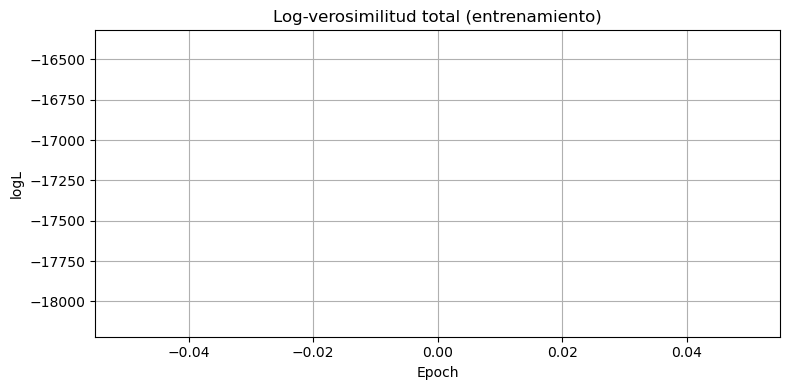

ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

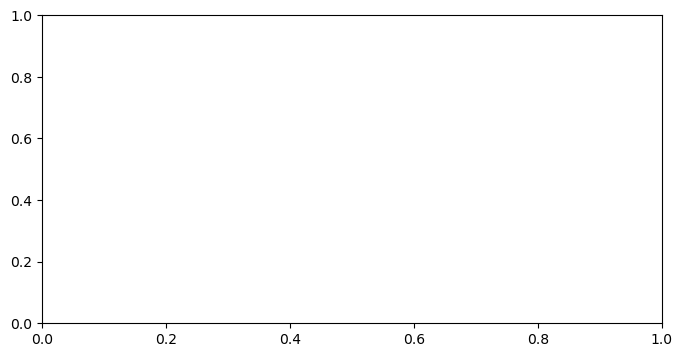

In [140]:
if __name__ == "__main__":
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    carpeta_entrenamiento = r"C:\Users\46028205\Desktop\TP2-Metodos\Entrenamiento"

    archivos = [f for f in os.listdir(carpeta_entrenamiento) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if not archivos:
        print("No se encontraron imágenes en la carpeta de entrenamiento")
        exit()

    # Probar vectorización con una imagen de ejemplo
    ruta_ejemplo = os.path.join(carpeta_entrenamiento, archivos[0])
    vector = vectorizar_imagen(ruta_ejemplo, size=(64, 64), normalizar=True)
    print("Vector shape:", vector.shape)
    print("Valores min y max:", vector.min(), vector.max())

    # Inicialización
    K = vector.shape[0]
    w_test = np.random.uniform(-0.1, 0.1, size=(K, 1))
    b_test = 0.0

    # Predicción inicial
    pred = prediccion_sigmoide(vector, w_test, b_test)
    print("Predicción ejemplo:", pred)

    # Log-verosimilitud inicial
    logL = logverosimilitud_total(carpeta_entrenamiento, w_test, b_test, size=(64, 64), normalizar=True)
    print("Log-verosimilitud total:", logL)

    # Accuracy inicial
    acc = accuracy_total(carpeta_entrenamiento, w_test, b_test, size=(64, 64), normalizar=True)
    print("Accuracy inicial:", acc)

    # ========================
    # ENTRENAMIENTO Y TESTING
    # ========================

    epochs = 100
    alpha = 0.05
    interval = 10
    historial_costos = []
    acc_train_hist = []
    acc_test_hist = []

    carpeta_testing = r"C:\Users\46028205\Desktop\TP2-Metodos\Testing"

    for epoch in range(epochs):
        dw = derivada_logverosimilitud_w(carpeta_entrenamiento, w_test, b_test, size=(64, 64), normalizar=True)
        db = derivada_logverosimilitud_b(carpeta_entrenamiento, w_test, b_test, size=(64, 64), normalizar=True)

        w_test += alpha * dw
        b_test += alpha * db

        logL = logverosimilitud_total(carpeta_entrenamiento, w_test, b_test, size=(64, 64), normalizar=True)
        historial_costos.append(logL)

        if epoch % interval == 0 or epoch == epochs - 1:
            acc_train = accuracy_total(carpeta_entrenamiento, w_test, b_test, size=(64, 64), normalizar=True)
            acc_test = accuracy_total(carpeta_testing, w_test, b_test, size=(64, 64), normalizar=True)

            acc_train_hist.append(acc_train)
            acc_test_hist.append(acc_test)

            print(f"Epoch {epoch+1}/{epochs} - logL = {-logL:.2f} | acc_train = {acc_train:.3f} | acc_test = {acc_test:.3f}")
           
            # ========================
            # VISUALIZACIÓN
            # ========================
        
            # Log-verosimilitud
            plt.figure(figsize=(8, 4))
            plt.plot(historial_costos)
            plt.title("Log-verosimilitud total (entrenamiento)")
            plt.xlabel("Epoch")
            plt.ylabel("logL")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
            # Accuracy
            x = list(range(0, epochs, interval))
            if epochs - 1 not in x:
                x.append(epochs - 1)
        
            plt.figure(figsize=(8, 4))
            plt.plot(x, acc_train_hist, label="Train Accuracy")
            plt.plot(x, acc_test_hist, label="Test Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.ylim(0, 1)
            plt.title("Accuracy durante el entrenamiento")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
